Edit of the chamberlain simulation (summation of all rays before squaring for power on the detector) to constrain rays to within a specific solid angle given in radians

In [5]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFunctions import * 
from random import uniform
import random
import pickle
import math
import time

# Single Ray, center axis. "Ideal" (no loss)

In [2]:
'''Runs the simulation with 1 ray down the center axis. power is simulated without pixels or airy pattern.'''
def RunOneRay_nopix(Lamd,Nsize,spo): #no pixels
    n = 1
    r = 0
    Rays = makeraysVERTICAL(spo,r,n) 
    #jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
    #Pix = MakePixels(jx,jy) #center of each pixel
    Ij = []
    Delay = []
    for y in np.linspace(-18,18,int(Nsize)): #nsize being number of positions of mirror
        PTot=0
        OutRays=RunRaysM(Rays,y) #eight each
        Ext = 0
        Eyt = 0
        for i in range(len(OutRays)): #per ray IN THIS PIXEL
            I = OutRays[i][1]
            thet = OutRays[i][0]
            phase = np.exp(1j*(OutRays[i][4]*2*np.pi/Lamd)) #factor of 2??
            Ex1 = np.sqrt(I)*np.cos(thet)
            Ey1 = np.sqrt(I)*np.sin(thet)
            Ex = Ex1*phase
            Ey = Ey1*phase
            Ext = Ext + Ex
            Eyt = Eyt + Ey
        PTot = PTot + (Ext*Ext.conjugate()).real + (Eyt*Eyt.conjugate()).real
        Delay.append(y*0.95630475596*4)
        Ij.append(PTot)
    return Delay,Ij

In [ ]:
Timei = time.time()
print('began: ',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(Timei)))
print('CURRENTLY RUNNING...')

Lamd =2.089
Timei = time.time()
Nsize = Nsized(Lamd)
#Nsize = 8192
Freq = float(300/Lamd)
spo = [-160.375,-113.,-80.0] #global CENTERED
spo1 = [-152.4375, -113.0,-80.]

Delay_center, Ij_center = RunOneRay_nopix(Lamd,Nsize,spo)
Timef = time.time()
print('COMPLETED')
print('total time: ~',float(Timef-Timei)/60, 'mins')

In [ ]:
d1 = Ij_center
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
#S = S[1:]
u = np.abs(S)
xtot = 36*0.95630475596*4 #total length of the scan
df = 1/xtot
f = df*np.arange(1+Nsize/2)-df/2

pl.plot(Delay_center,Ij_center,linewidth = .8) 
pl.tick_params(colors = 'black')
#pl.title('$\lambda$='+str(Lamd),color = 'black')
pl.xlabel('Optical Delay (mm)', color = 'black')
#pl.savefig('1CenterRayInt.png',dpi=1000)
pl.show() 

pl.plot(300*f[3:],u[3:])
#pl.title('FFT of above',color = 'black')
pl.xlabel('GHz', color = 'black')
pl.tick_params(colors = 'black')
pl.axvline(x =float(Freq), color = 'green', label = str(Freq)+'GHz')
pl.xlim(0,200)
pl.legend()
#pl.savefig('1CenterRaySpec.png',dpi=1000)
pl.show()
#with one ray

# Chamberlain loss. Loss due to different in path length because of angle change from large etendue. 

In [6]:
'''Simulation of interference of probability function of a single photon. 500 rays with initial phase of zero from a single source point, random launch points, and power is summed before squared. To show Chamberlain loss (large etendue) '''
def RunRays_Prob_narrow(Lamd,Nsize,spo,lim):
    n = 500
    r = 0
    thetG = [0,0,0]
    #Rays = makeraysVERTICAL(spo,r,n) 
    Rays = makerays_Zero_narrow(spo,thetG,r,n,lim) #lim is solid angle wanted
    #jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
    #Pix = MakePixels(jx,jy) #center of each pixel
    Ij = []
    Delay = []
    for y in np.linspace(-18,18,int(Nsize)):
        PTot=0
        OutRays=RunRaysM(Rays,y) #all rays that made it through the detector
        #Overlap = gaussoverlap(OutRays[0],OutRays[5],3.3) #two paths that hit two different spots 
        #for j in range(len(Pix)): #per PIXEL
        for j in range(1): #no pixels
            Ex4i = 0 #adding PER PIXEL from parts of RAYS in this PIXEL
            Ey4i = 0 #THIS IS WHERE THEY WILL INTERFERE
            for i in range(len(OutRays)): #per ray IN THIS PIXEL
                I = OutRays[i][1] #amplitude
                thet = OutRays[i][0] #polarization
                phase = np.exp(1j*(OutRays[i][4]*2*np.pi/Lamd)) #e^ix2pi/lambda, x = distance traveleld
                Ex1 = np.sqrt(I)*np.cos(thet) #polarization
                Ey1 = np.sqrt(I)*np.sin(thet)
                Ex = Ex1*phase #phase
                Ey = Ey1*phase
                #doing summation over entire detector
                #sig,mux,muy = MakeGaussian(OutRays[i],Lamd)
                #Gr = Airygaussian3dNORM(Pix[j][0],Pix[j][1],sig,mux,muy)
                Gr = 1
                Ex4i = Ex4i + Gr*Ex #add electric fields of all rays
                Ey4i = Ey4i + Gr*Ey
            PTot = PTot + (Ex4i*Ex4i.conjugate()).real + (Ey4i*Ey4i.conjugate()).real
        Delay.append(y*0.95630475596*4)
        Ij.append(PTot)
    return Delay,Ij



In [7]:
Timei = time.time()
print('began: ',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(Timei)))
print('CURRENTLY RUNNING...')

Lamd =2.089
Timei = time.time()
Nsize = Nsized(Lamd)
#Nsize = 8192
Freq = float(300/Lamd)
spo = [-160.375,-113.,-80.0] #global CENTERED
spo1 = [-152.4375, -113.0,-80.]
spo2 = [-161.375,-113.,-80.0] #1mm moved in x plane
#lim = np.pi/6 #30 degrees
#lim= np.pi/9 #20 degrees
#lim = np.pi/18 #10 degrees

Delay1, Ij1 = RunRays_Prob_narrow(Lamd,Nsize,spo2,np.pi/18)
Timef = time.time()
print('COMPLETED')
print('total time: ~',float(Timef-Timei)/60, 'mins')

began:  2019-07-03 17:46:49
CURRENTLY RUNNING...
COMPLETED
total time: ~ 310.28533571163814 mins


In [8]:
with open("Ij_Chamb_144_Narrow_10_-161.375_"+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as F:
    pickle.dump(Ij1,F)
with open("Delay_Chamb_144_Narrow_10_-161.375_"+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as F:
    pickle.dump(Delay1,F)

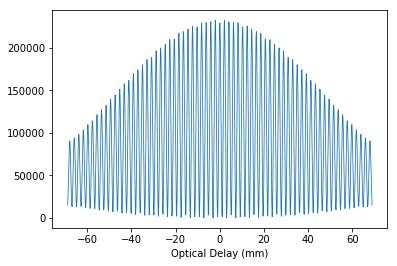

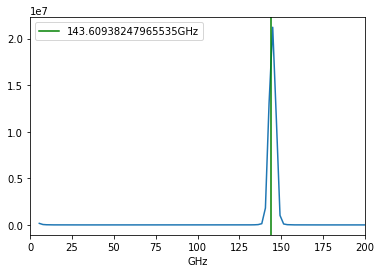

In [9]:
d1 = Ij1
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
#S = S[1:]
u = np.abs(S)
xtot = 36*0.95630475596*4 #total length of the scan
df = 1/xtot
f = df*np.arange(1+Nsize/2)-df/2

pl.plot(Delay1,Ij1,linewidth = .8) 
pl.tick_params(colors = 'black')
#pl.title('$\lambda$='+str(Lamd),color = 'black')
pl.xlabel('Optical Delay (mm)', color = 'black')
#pl.savefig('1CenterRayInt.png',dpi=1000)
pl.show() 

pl.plot(300*f[3:],u[3:])
#pl.title('FFT of above',color = 'black')
pl.xlabel('GHz', color = 'black')
pl.tick_params(colors = 'black')
pl.axvline(x =float(Freq), color = 'green', label = str(Freq)+'GHz')
pl.xlim(0,200)
pl.legend()
#pl.savefig('1CenterRaySpec.png',dpi=1000)
pl.show()
#with one ray

# STANDARD (not narrow) Chamberlain effect as comparison

In [12]:
Timei = time.time()
print('began: ',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(Timei)))
print('CURRENTLY RUNNING...')

Lamd =2.089
Timei = time.time()
Nsize = Nsized(Lamd)
#Nsize = 8192
Freq = float(300/Lamd)
spo = [-160.375,-113.,-80.0] #global CENTERED
spo1 = [-152.4375, -113.0,-80.]

#lim = np.pi/6 #30 degrees
#lim= np.pi/9 #20 degrees
#lim = np.pi/18 #10 degrees

Delay1, Ij1 = RunRays_Prob(Lamd,Nsize,spo)
Timef = time.time()
print('COMPLETED')
print('total time: ~',float(Timef-Timei)/60, 'mins')

began:  2019-05-30 14:49:32
CURRENTLY RUNNING...
COMPLETED
total time: ~ 195.0583976149559 mins


In [13]:
with open("Ij_Chamb_144_Narrow_NOLIM_"+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as F:
    pickle.dump(Ij1,F)
with open("Delay_Chamb_144_Narrow_NOLIM_"+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as F:
    pickle.dump(Delay1,F)

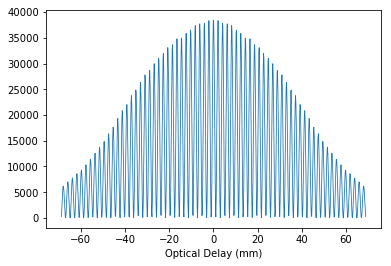

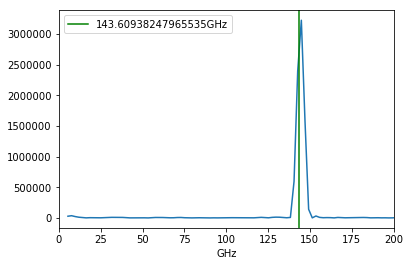

In [14]:
d1 = Ij1
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
#S = S[1:]
u = np.abs(S)
xtot = 36*0.95630475596*4 #total length of the scan
df = 1/xtot
f = df*np.arange(1+Nsize/2)-df/2

pl.plot(Delay1,Ij1,linewidth = .8) 
pl.tick_params(colors = 'black')
#pl.title('$\lambda$='+str(Lamd),color = 'black')
pl.xlabel('Optical Delay (mm)', color = 'black')
#pl.savefig('1CenterRayInt.png',dpi=1000)
pl.show() 

pl.plot(300*f[3:],u[3:])
#pl.title('FFT of above',color = 'black')
pl.xlabel('GHz', color = 'black')
pl.tick_params(colors = 'black')
pl.axvline(x =float(Freq), color = 'green', label = str(Freq)+'GHz')
pl.xlim(0,200)
pl.legend()
#pl.savefig('1CenterRaySpec.png',dpi=1000)
pl.show()
#with one ray

# Geometric loss. Loss due to scattering of rays. 

In [ ]:
def Part1_narrow(Lamd,Nsize,spo): 
    n = 1
    r = 0
    thetG = [0,0,0]
    Rays = makerays_narrow(spo,thetG,r,n) 
    Ij = []
    Delay = []
    Number = [] #number of rays that hit detector as function of mirror position (y)
    for y in np.linspace(-18,18,int(Nsize)):
        PTot=0
        OutRays=RunRaysM(Rays,y) #eight each if n =1
        if len(OutRays)==0:
            PTot=0
        else:
            Ex4i = 0
            Ey4i = 0
            for i in range(len(OutRays)): #per ray that hit detector
                I = OutRays[i][1]
                thet = OutRays[i][0]
                phase = np.exp(1j*(OutRays[i][4]*2*np.pi/Lamd)) #factor of 2??
                Ex1 = np.sqrt(I)*np.cos(thet)
                Ey1 = np.sqrt(I)*np.sin(thet)
                Ex = Ex1*phase
                Ey = Ey1*phase
                Gr = 1
                Ex4i = Ex4i + Gr*Ex
                Ey4i = Ey4i + Gr*Ey
            PTot = PTot + (Ex4i*Ex4i.conjugate()).real + (Ey4i*Ey4i.conjugate()).real
        Delay.append(y*0.95630475596*4)
        Ij.append(PTot)
        Number.append(len(OutRays))
    return Delay,Ij,Number

def RunNRays_NoPix_narrow(Lamd,Nsize,spo,n): #multiple individual rays.
    Ij = np.zeros(Nsize) #empty array of proper size
    Numz = np.zeros(Nsize)
    for i in range(int(n)):
        Delay,Pow1,Num = Part1_narrow(Lamd,Nsize,spo)
        Numz = Numz+np.array(Num)
        Ij = Ij + np.array(Pow1)
    return Delay,Ij,Numz
        

In [ ]:
Timei = time.time()
print('began: ',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(Timei)))
print('CURRENTLY RUNNING...')

Lamd =2.089
Timei = time.time()
Nsize = Nsized(Lamd)
#Nsize = 8192
Freq = float(300/Lamd)
spo = [-160.375,-113.,-80.0] #global CENTERED
spo1 = [-152.4375, -113.0,-80.]

Delay_Geom, Ij_Geom,Num_Geom = RunNRays_NoPix_narrow(Lamd,Nsize,spo,500)
Timef = time.time()
print('COMPLETED')
print('total time: ~',float(Timef-Timei)/60, 'mins')

In [ ]:
with open("Ij_Geom_144_Narrow_30_"+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as F:
    pickle.dump(Ij_Geom,F)
with open("Delay_Geom_144_Narrow_30_"+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as F:
    pickle.dump(Delay_Geom,F)

In [ ]:
d1 = Ij_Geom
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
#S = S[1:]
u = np.abs(S)
xtot = 36*0.95630475596*4 #total length of the scan
df = 1/xtot
f = df*np.arange(1+Nsize/2)-df/2

pl.plot(Delay_Geom,Ij_Geom,linewidth = .8) 
pl.tick_params(colors = 'black')
#pl.title('$\lambda$='+str(Lamd),color = 'black')
pl.xlabel('Optical Delay (mm)', color = 'black')
#pl.savefig('1CenterRayInt.png',dpi=1000)
pl.show() 

pl.plot(300*f[3:],u[3:])
#pl.title('FFT of above',color = 'black')
pl.xlabel('GHz', color = 'black')
pl.tick_params(colors = 'black')
pl.axvline(x =float(Freq), color = 'green', label = str(Freq)+'GHz')
pl.xlim(0,200)
pl.legend()
#pl.savefig('1CenterRaySpec.png',dpi=1000)
pl.show()
#with one ray